## Libraries import

In [2]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from sklearn.model_selection import validation_curve


# Tree print
from sklearn.tree import export_graphviz

# warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  #hide any pandas warnings

sns.set(style="whitegrid", color_codes=True)

### Define utility functions

In [3]:
# Define confusion matrix function
def do_confusion_matrix(Y, prediction):
    cm = confusion_matrix(Y, prediction)
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm_df, annot=True, square=True, cmap="YlGnBu")
    plt.tight_layout()
    plt.show()
    print("Sensitivity (True Positives Rate):", np.round(cm[0,0]/(cm[0,0] + cm[1,0]), 2))
    print("Specificity (True Negatives Rate):", np.round(cm[1,1]/(cm[1,1] + cm[0,1]), 2))
    
# Define feature importance function
def do_feature_importance(model, x, y):
    model.fit(x, y)
    feature_importance = pd.DataFrame(model.feature_importances_, index=x.columns, columns=['RFC']).sort_values('RFC', ascending=False)

    sns.barplot(x=feature_importance.values[:,0], y=feature_importance.index, palette="deep")
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()
    model = None
    
def do_validation_curve(classifier, x, y, param_name, param_range):
    train_scores, test_scores = validation_curve(
                                    classifier,
                                    X=x, y=y, 
                                    param_name=param_name, 
                                    param_range=param_range,
                                    cv = 3)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 5))
    plt.title("Validation Curve with RFC")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.6, 1.1)
    lw = 1
    plt.plot(param_range, train_scores_mean,'.-', label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, '.-', label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    
    return test_scores_mean

def do_test_set_hyperparameter_tuning(x_train, x_test, y_train, y_test, param_name, param_range):
    train_results = []
    test_results = []
    for param in param_range:
        model = RandomForestClassifier(**{param_name: param, 'random_state': 50})
        model.fit(x_train, y_train)

        # Train prediction
        train_pred = model.predict(x_train)
        accuracy = accuracy_score(y_train, train_pred)
        train_results.append(accuracy)

        # Test prediction
        test_pred = model.predict(x_test)
        accuracy = accuracy_score(y_test, test_pred)
        test_results.append(accuracy)
        model = None

    plt.figure(figsize=(10, 5))
    plt.title("Accuracy")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.6, 1.1)
    lw = 1
    plt.plot(param_range, train_results,'.-', label="Training score",
                 color="darkorange", lw=lw)
    plt.plot(param_range, test_results, '.-', label="Test score",
                 color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    print("Max Test Score:", np.round(np.max(test_results)*100, 3))
    print("Best Param Value:", param_range[np.argmax(test_results)])

## Read data

In [4]:
file_name = 'heart_big.csv'
ds = pd.read_csv(file_name)

# Drop rows with thal equal to 0
ds.drop(ds[ds['thal'] == 0].index, axis=0, inplace=True)

### Rename of columns and type conversion

In [5]:
# Columns rename
ds.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

# Modifico i valori in modo da identificare con chiarezza le
# feature categoriche
ds['sex'][ds['sex'] == 0] = 'female'
ds['sex'][ds['sex'] == 1] = 'male'

ds['chest_pain_type'][ds['chest_pain_type'] == 0] = 'typical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 1] = 'atypical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 2] = 'non-anginal pain'
ds['chest_pain_type'][ds['chest_pain_type'] == 3] = 'asymptomatic'

ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

ds['rest_ecg'][ds['rest_ecg'] == 0] = 'normal'
ds['rest_ecg'][ds['rest_ecg'] == 1] = 'ST-T wave abnormality'
ds['rest_ecg'][ds['rest_ecg'] == 2] = 'left ventricular hypertrophy'

ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 0] = 'no'
ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 1] = 'yes'

ds['st_slope'][ds['st_slope'] == 0] = 'upsloping'
ds['st_slope'][ds['st_slope'] == 1] = 'flat'
ds['st_slope'][ds['st_slope'] == 2] = 'downsloping'

ds['thalassemia'][ds['thalassemia'] == 1] = 'normal'
ds['thalassemia'][ds['thalassemia'] == 2] = 'fixed defect'
ds['thalassemia'][ds['thalassemia'] == 3] = 'reversable defect'


# Converto i tipi in modo corretto

ds['sex'] = ds['sex'].astype('object')
ds['chest_pain_type'] = ds['chest_pain_type'].astype('object')
ds['fasting_blood_sugar'] = ds['fasting_blood_sugar'].astype('object')
ds['rest_ecg'] = ds['rest_ecg'].astype('object')
ds['exercise_induced_angina'] = ds['exercise_induced_angina'].astype('object')
ds['st_slope'] = ds['st_slope'].astype('object')
ds['thalassemia'] = ds['thalassemia'].astype('object')

## Exploratory data analysis

##### Dimensions of dataset

In [6]:
print("Rows:", ds.shape[0], "\nFeatures:", ds.shape[1])

Rows: 1018 
Features: 14


##### Missing values

In [7]:
print("There are missing values?", ds.isnull().values.any(), "\n")

There are missing values? False 



##### Data info
Checks correct conversion of data types

In [8]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1018 entries, 0 to 1024
Data columns (total 14 columns):
age                        1018 non-null int64
sex                        1018 non-null object
chest_pain_type            1018 non-null object
resting_blood_pressure     1018 non-null int64
cholesterol                1018 non-null int64
fasting_blood_sugar        1018 non-null object
rest_ecg                   1018 non-null object
max_heart_rate_achieved    1018 non-null int64
exercise_induced_angina    1018 non-null object
st_depression              1018 non-null float64
st_slope                   1018 non-null object
num_major_vessels          1018 non-null int64
thalassemia                1018 non-null object
target                     1018 non-null int64
dtypes: float64(1), int64(6), object(7)
memory usage: 119.3+ KB


##### Dataset sample

In [9]:
# Dataset sample
ds.sample(frac=0.01)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
549,68,male,non-anginal pain,118,277,lower than 120mg/ml,ST-T wave abnormality,151,no,1.0,downsloping,1,reversable defect,1
175,56,female,typical angina,200,288,greater than 120mg/ml,normal,133,yes,4.0,upsloping,2,reversable defect,0
90,54,female,non-anginal pain,108,267,lower than 120mg/ml,normal,167,no,0.0,downsloping,0,fixed defect,1
755,48,male,non-anginal pain,124,255,greater than 120mg/ml,ST-T wave abnormality,175,no,0.0,downsloping,2,fixed defect,1
700,41,male,non-anginal pain,130,214,lower than 120mg/ml,normal,168,no,2.0,flat,0,fixed defect,1
799,43,male,typical angina,115,303,lower than 120mg/ml,ST-T wave abnormality,181,no,1.2,flat,0,fixed defect,1
234,49,female,typical angina,130,269,lower than 120mg/ml,ST-T wave abnormality,163,no,0.0,downsloping,0,fixed defect,1
409,46,male,non-anginal pain,150,231,lower than 120mg/ml,ST-T wave abnormality,147,no,3.6,flat,0,fixed defect,0
338,56,male,non-anginal pain,130,256,greater than 120mg/ml,normal,142,yes,0.6,flat,1,normal,0
456,47,male,non-anginal pain,108,243,lower than 120mg/ml,ST-T wave abnormality,152,no,0.0,downsloping,0,fixed defect,0


##### Dataset description

In [10]:
ds.describe()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target
count,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000
mean,54.447937,131.636542,246.253438,149.187623,1.074951,0.759332,0.513752
std,9.101835,17.574327,51.676406,23.006116,1.177640,1.032432,0.500057
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000
25%,48.000000,120.000000,211.000000,132.000000,0.000000,0.000000,0.000000
50%,56.000000,130.000000,240.000000,152.000000,0.800000,0.000000,1.000000
75%,61.000000,140.000000,275.750000,166.000000,1.800000,1.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000,1.000000


##### Correlation heatmap

Uso solo i dati numerici per ottenere una matrice di correlazione

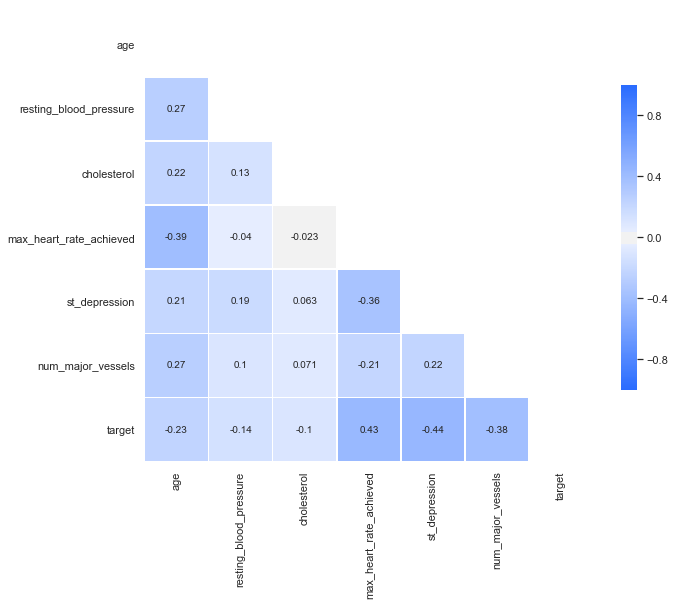

In [11]:
corr = ds.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
cmap = sns.diverging_palette(260, 260, s=100, l=50, n=9, as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-1, center=0, square=True, linewidth=.5, cbar_kws={'shrink': .5}, annot=True, mask=mask, cmap=cmap)
plt.tight_layout()
plt.show()

#### Categorical features handling

##### Dummy fetures creation

In [12]:
ds = pd.get_dummies(ds, drop_first=True)

### Data distriutions

##### Target distribution

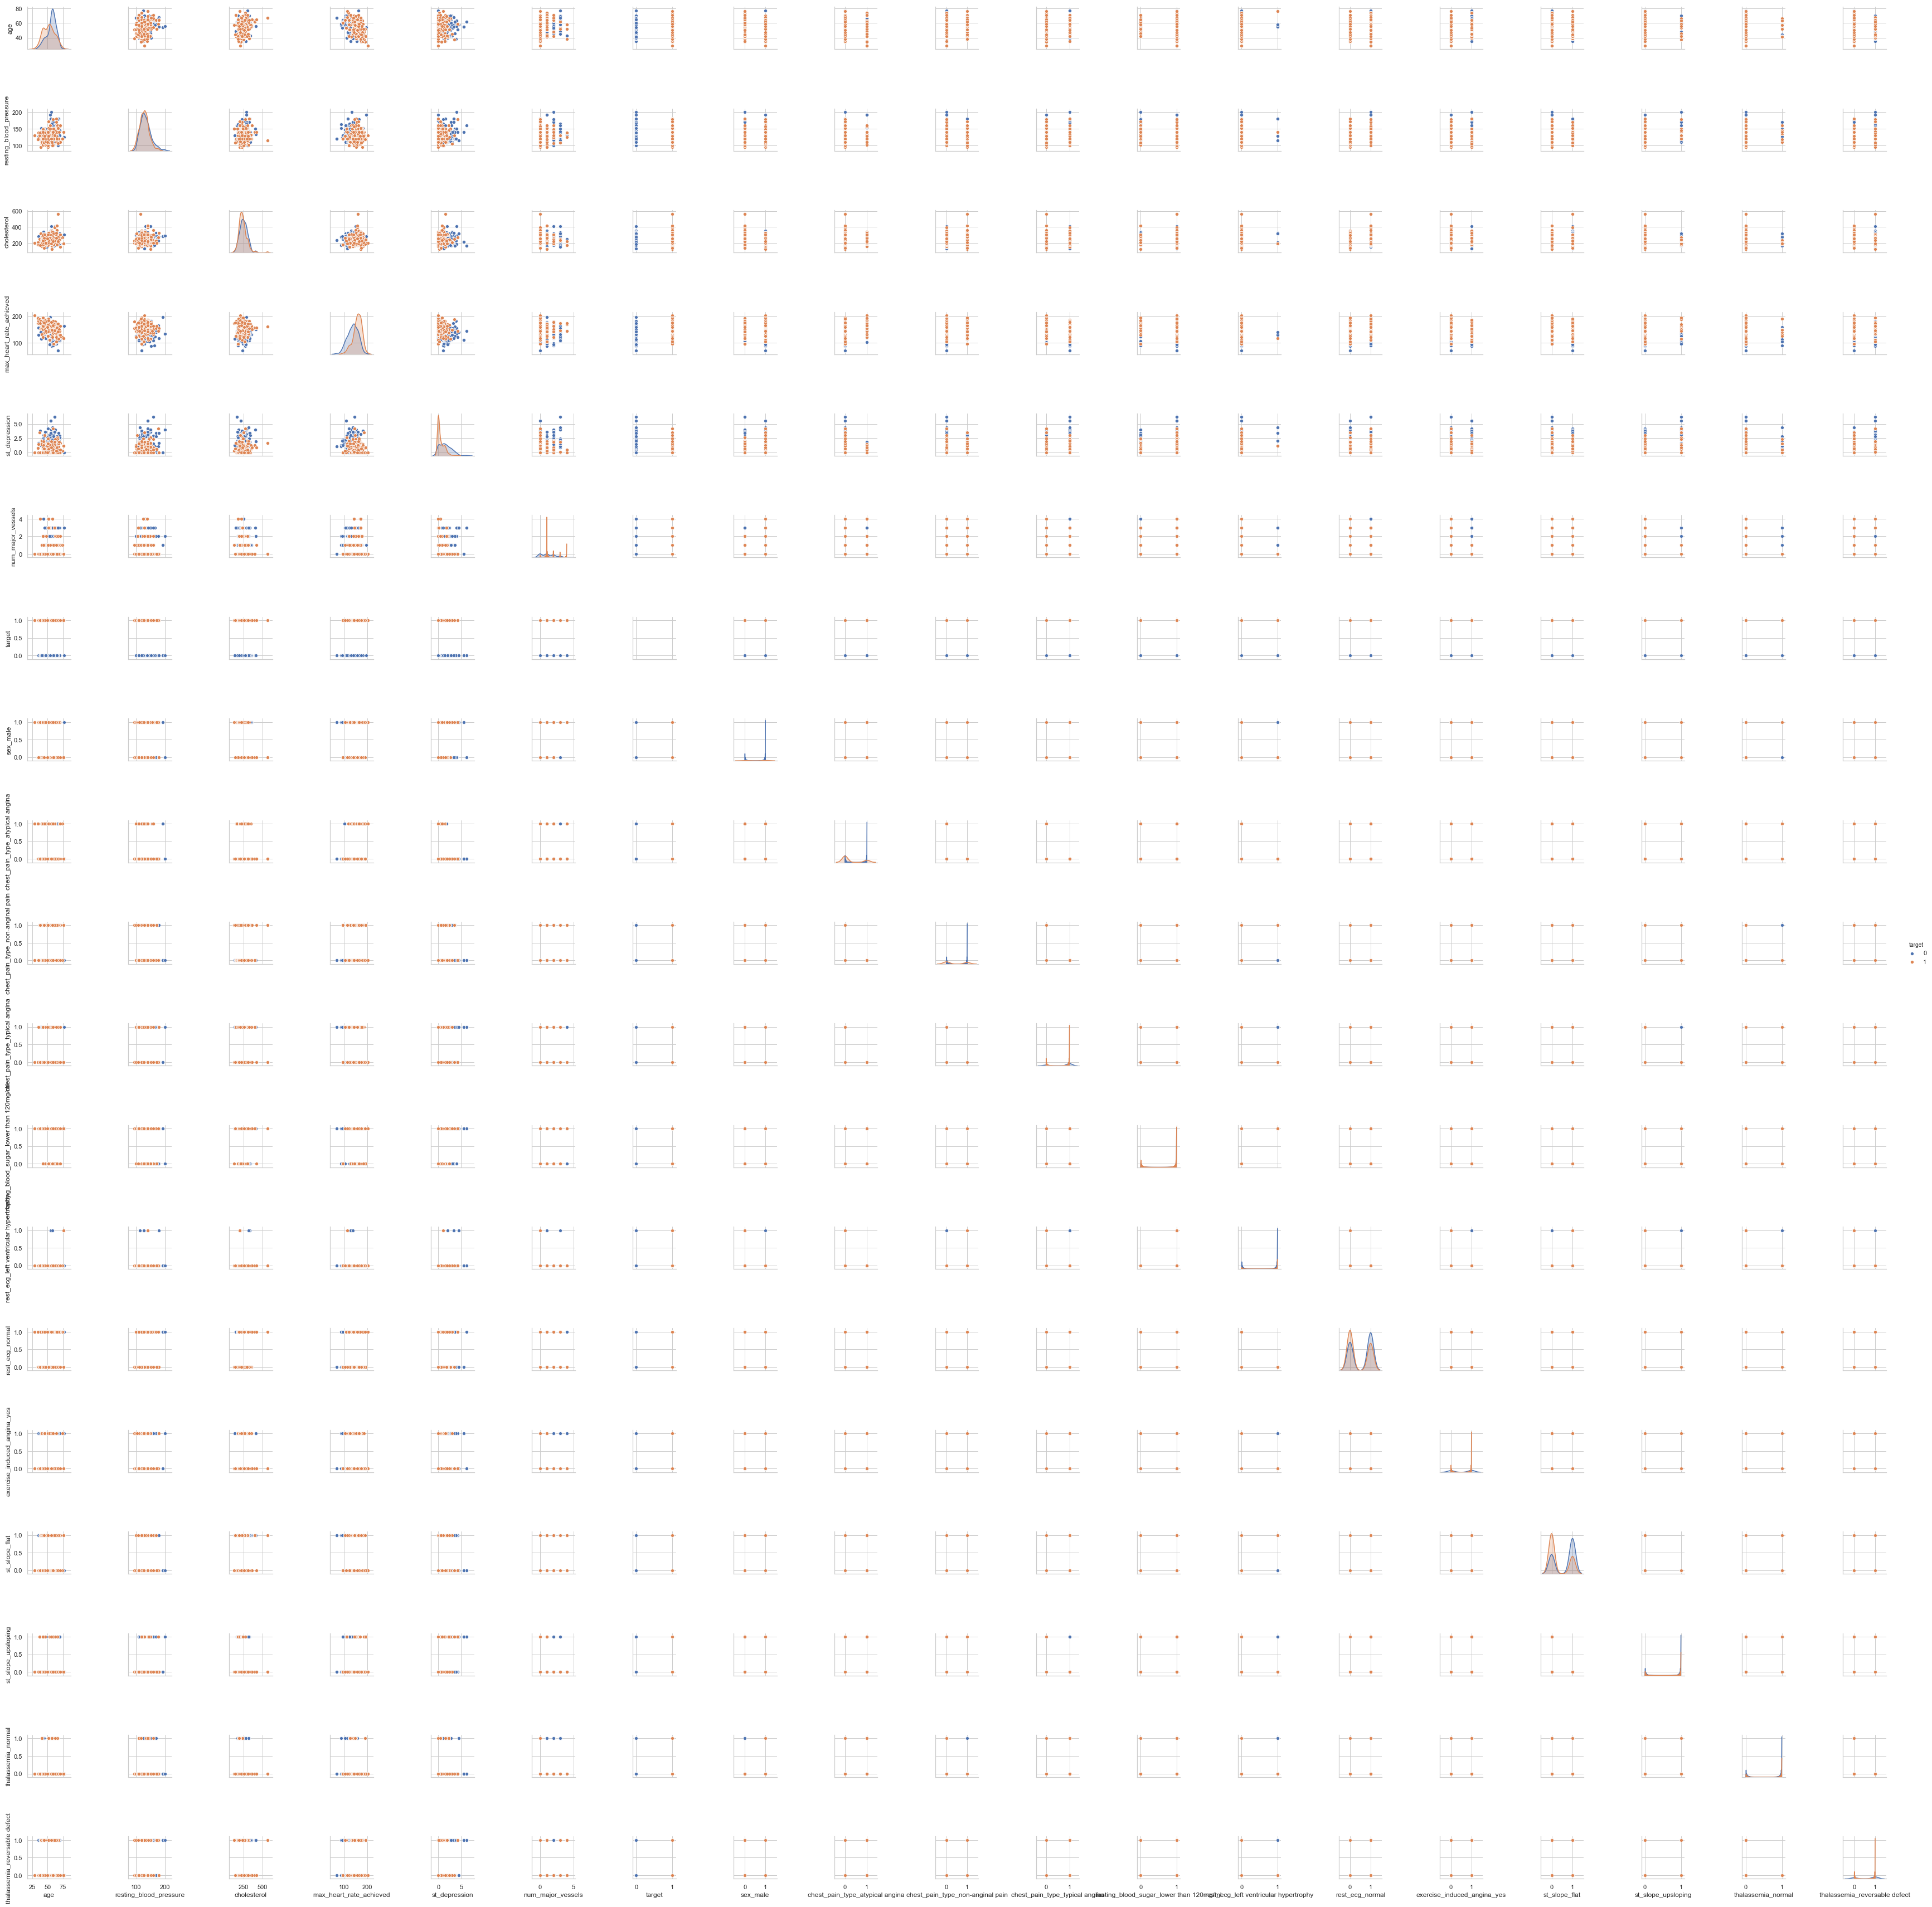

In [37]:
#sns.distplot(ds["target"], hist=True)
#plt.show()
sns.pairplot(data=ds, hue='target')
plt.show()

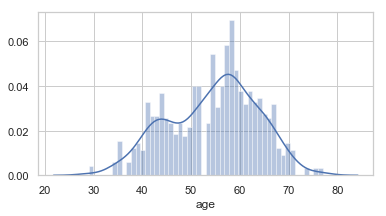

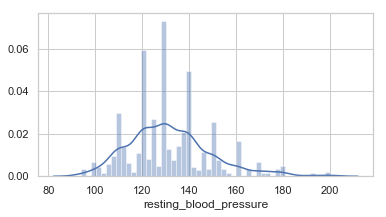

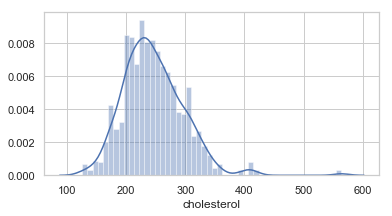

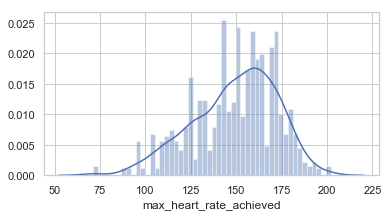

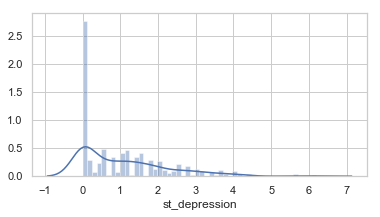

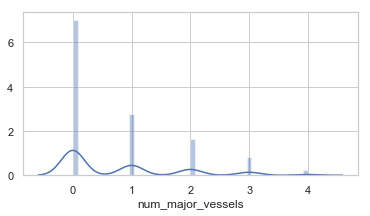

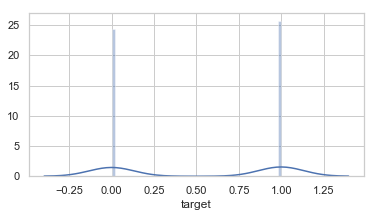

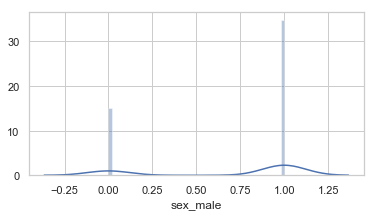

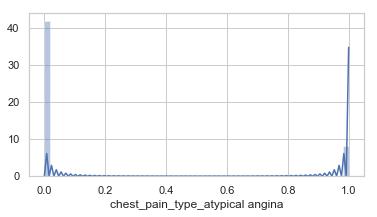

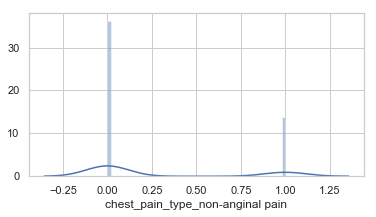

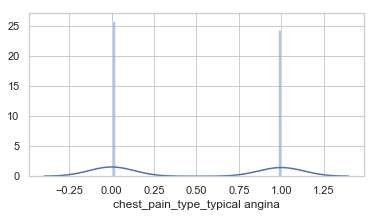

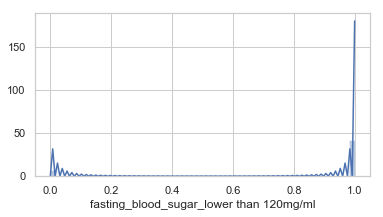

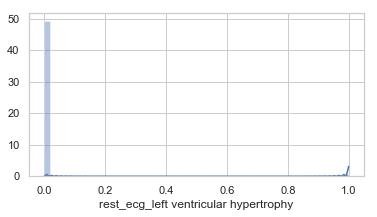

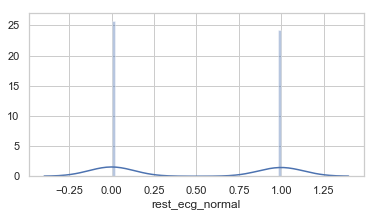

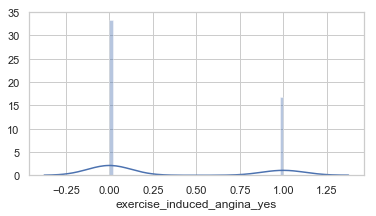

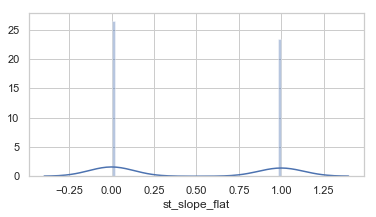

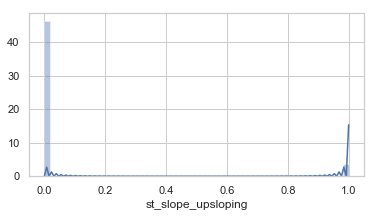

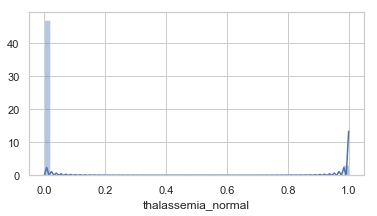

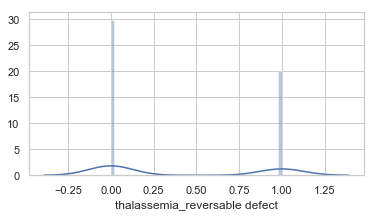

In [14]:
for c in ds.columns:
    plt.figure(figsize=(6, 3))
    sns.distplot(ds[c], hist=True, bins=50)
    plt.show()

## Model implementation and tuning

##### Split dataset in input values and values to predict

In [15]:
X = ds.drop(['target'], axis=1) # X -> data
Y = ds['target'] # Y -> values to predict

#### Feature importance
Uso RFC per estrarre le features più importanti

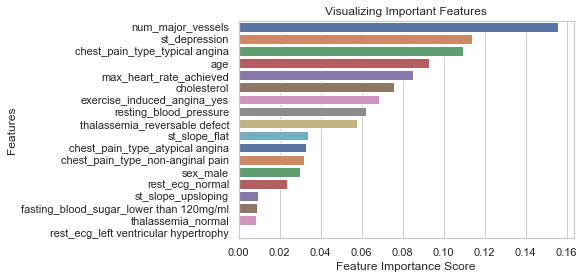

In [16]:
model = RandomForestClassifier(random_state = 50)
do_feature_importance(model, X, Y)

#### Data Normalization

In [17]:
scaler = preprocessing.StandardScaler()
columns_names = X.columns
# Fit your data on the scaler object
X_scaled = X
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=columns_names)
X_scaled.describe()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_normal,thalassemia_reversable defect
count,1.018000e+03,1.018000e+03,1.018000e+03,1.018000e+03,1.018000e+03,1.018000e+03,1.018000e+03,1.018000e+03,1.018000e+03,1.018000e+03,1.018000e+03,1.018000e+03,1.018000e+03,1.018000e+03,1.018000e+03,1.018000e+03,1.018000e+03,1.018000e+03
mean,3.210704e-16,-5.025450e-16,-2.303331e-16,1.151666e-16,7.328781e-17,-3.140906e-17,-1.273812e-16,-6.630802e-17,-9.073728e-17,-6.979791e-18,-3.489896e-18,-2.093937e-17,-9.771708e-17,-4.362369e-17,-8.899234e-17,-5.932822e-17,4.711359e-17,-2.093937e-17
std,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00
min,-2.797287e+00,-2.142616e+00,-2.328191e+00,-3.400229e+00,-9.132499e-01,-7.358405e-01,-1.514760e+00,-4.429895e-01,-6.174751e-01,-9.690447e-01,-2.414998e+00,-1.222912e-01,-9.709522e-01,-7.097132e-01,-9.408428e-01,-2.799818e-01,-2.590096e-01,-8.211834e-01
25%,-7.087699e-01,-6.624585e-01,-6.825313e-01,-7.474565e-01,-9.132499e-01,-7.358405e-01,-1.514760e+00,-4.429895e-01,-6.174751e-01,-9.690447e-01,4.140790e-01,-1.222912e-01,-9.709522e-01,-7.097132e-01,-9.408428e-01,-2.799818e-01,-2.590096e-01,-8.211834e-01
50%,1.706058e-01,-9.316696e-02,-1.210710e-01,1.223048e-01,-2.335910e-01,-7.358405e-01,6.601705e-01,-4.429895e-01,-6.174751e-01,-9.690447e-01,4.140790e-01,-1.222912e-01,-9.709522e-01,-7.097132e-01,-9.408428e-01,-2.799818e-01,-2.590096e-01,-8.211834e-01
75%,7.202156e-01,4.761246e-01,5.710742e-01,7.311378e-01,6.159826e-01,2.332224e-01,6.601705e-01,-4.429895e-01,1.619499e+00,1.031944e+00,4.140790e-01,-1.222912e-01,1.029917e+00,1.409020e+00,1.062877e+00,-2.799818e-01,-2.590096e-01,1.217755e+00
max,2.478967e+00,3.891874e+00,6.151797e+00,2.296708e+00,4.354106e+00,3.140411e+00,6.601705e-01,2.257390e+00,1.619499e+00,1.031944e+00,4.140790e-01,8.177204e+00,1.029917e+00,1.409020e+00,1.062877e+00,3.571660e+00,3.860861e+00,1.217755e+00


### Train Set and Validation Set Split
##### Split train set and test set (train: 75% test: 25%)


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.25, random_state = 50)
print("Train set:", int(np.round(X_train.shape[0]/X.shape[0]*100)), "%  ", "({}/{})".format(X_train.shape[0], X.shape[0]))
print("Test set:", int(np.round(X_test.shape[0]/X.shape[0]*100)), "%   ", "({}/{})".format(X_test.shape[0], X.shape[0]))

Train set: 75 %   (763/1018)
Test set: 25 %    (255/1018)


##### First attempt without tuning

Accuracy Score (without Hyperparameters Tuning): 98.039%


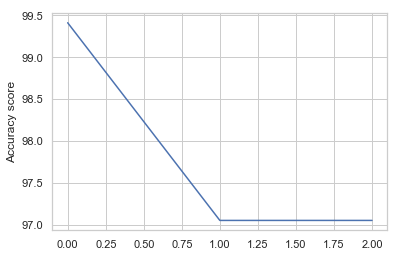

Accuracy CV: 97.83733333333333 %


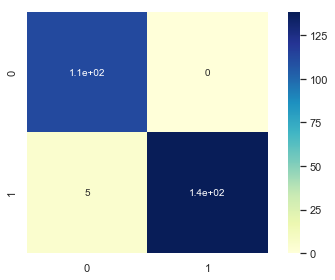

Sensitivity (True Positives Rate): 0.96
Specificity (True Negatives Rate): 1.0


In [19]:
model = RandomForestClassifier(random_state=50)
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
accuracy = accuracy_score(Y_test, prediction)
print("Accuracy Score (without Hyperparameters Tuning):", "{}%".format(np.round(100*accuracy,3)))
accuracy = cross_val_score(model, X_scaled, Y, cv = 3, scoring = 'accuracy')
accuracy = np.round(accuracy * 100, 3)

model = None

plt.plot(accuracy, 'b', label="Training Acc")
plt.ylabel('Accuracy score')
plt.show()
print("Accuracy CV:", np.mean(accuracy), "%")

do_confusion_matrix(Y_test, prediction)

#do_feature_importance(model, X_scaled, Y)

model = None
prediction = None
accuracy = None

### Hyperparameters tuning

##### Hyperparameters define

In [31]:
max_features = list(range(1,X_scaled.shape[1]))
n_estimators = [2, 4, 8, 16, 32, 64, 100, 300]
max_depth = [2, 4, 6, 8, 9, 10, 15, 20]


hyperF = dict(n_estimators=n_estimators,
              max_features=max_features,
              max_depth=max_depth)

#### Validation curve tuning ()

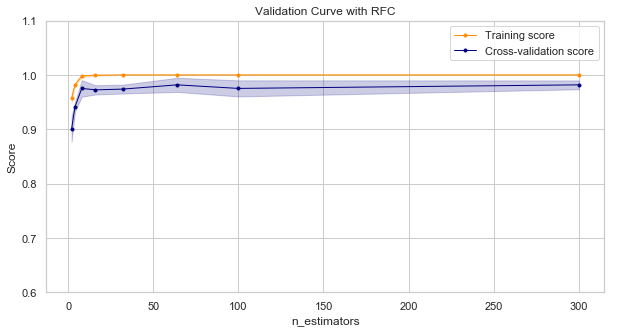

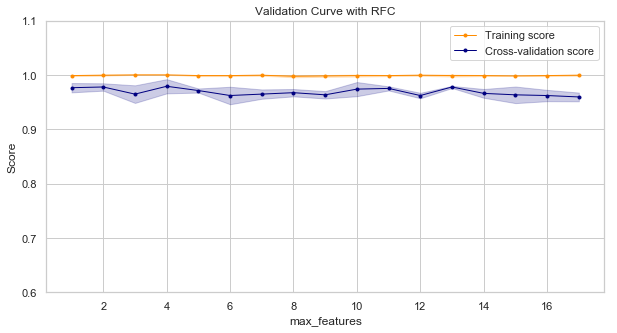

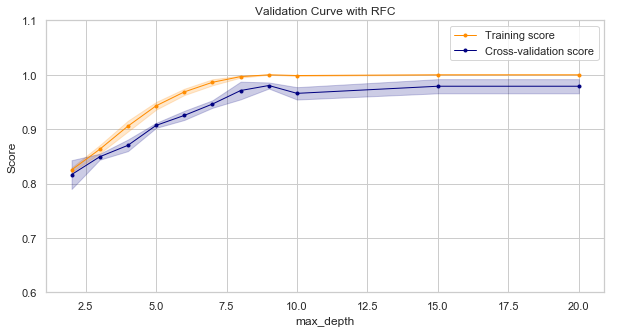

Best Hyperparameters values:
n_estimators :  64
max_features :  4
max_depth :  9


In [29]:
# Tuning n_estimators
best_hyp = dict()
test_scores_mean = do_validation_curve(RandomForestClassifier(random_state=50), X_train, Y_train, 'n_estimators', n_estimators)
best_hyp["n_estimators"] = n_estimators[np.argmax(test_scores_mean)]

# Tuning max_features
test_scores_mean = do_validation_curve(RandomForestClassifier(random_state=50), X_train, Y_train, 'max_features', max_features)
best_hyp["max_features"] = max_features[np.argmax(test_scores_mean)]

## Tuning min_samples_leaf
## test_scores_mean = do_validation_curve(RandomForestClassifier(random_state=50), X_train, Y_train, 'min_samples_leaf', min_samples_leaf)
## print("Best min_samples_leaf:", min_samples_leaf[np.argmax(test_scores_mean)])

## Tuning max_depth
test_scores_mean = do_validation_curve(RandomForestClassifier(random_state=50), X_train, Y_train, 'max_depth', max_depth)

best_hyp["max_depth"] = max_depth[np.argmax(test_scores_mean)]

## Tuning bootstrap
## test_scores_mean = do_validation_curve(RandomForestClassifier(ranbest_hyp["max_features"] = max_features[np.argmax(test_scores_mean)]
## print("Best bootstrap:", bootstrap[np.argmax(test_scores_mean)])

print("Best Hyperparameters values:")
for k in best_hyp:
    print(k, ": ", best_hyp[k])

#### Test set tuning

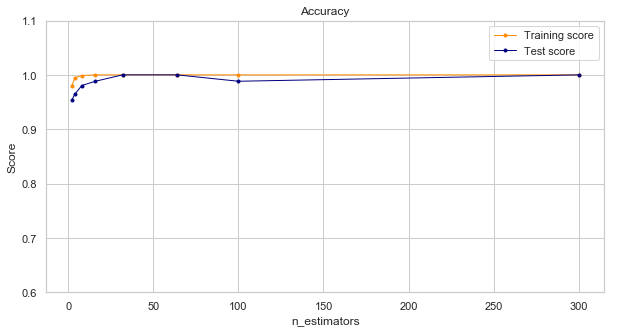

Max Test Score: 100.0
Best Param Value: 32


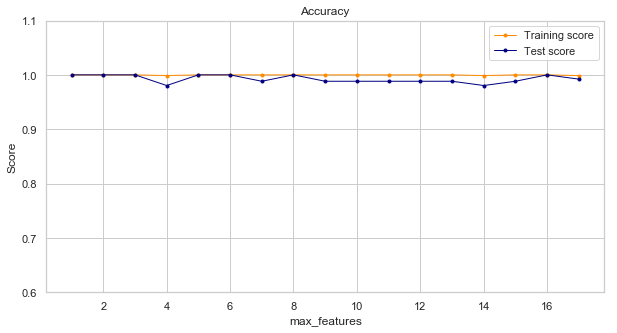

Max Test Score: 100.0
Best Param Value: 1


In [84]:
#################################
#### SBAGLIATO PROBABILMENTE ####
#################################

do_test_set_hyperparameter_tuning(X_train, X_test, Y_train, Y_test, "n_estimators", n_estimators)
do_test_set_hyperparameter_tuning(X_train, X_test, Y_train, Y_test, "max_features", max_features)

#### Exhaustive GridSearchCV Tuning

##### GridSearchCV

In [30]:
gridF = GridSearchCV(RandomForestClassifier(random_state=50), hyperF, cv = 10, verbose = 1, n_jobs = -1)
bestF = gridF.fit(X_train, Y_train)

Fitting 10 folds for each of 1496 candidates, totalling 14960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 583 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 1338 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2261 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3322 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4653 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6249 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 8153 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 10033 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 12133 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 14662 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 14960 out of 14960 | elapsed: 13.9min finished


##### Cross Validation

In [ ]:
accuracyCV = cross_val_score(bestF, X_train, Y_train, cv = 10, scoring = 'accuracy')

print()
print("*"*50)
print("\n\n")
print("Cross Validation Scores")
plt.plot(accuracyCV, '.-b', label="Accuracy CV")
plt.ylabel('Accuracy score')
plt.show()
print("CV Mean Accuracy Score:", np.round(np.mean(100*accuracyCV), 3), "%")
print()
print("*"*50)
print("\n\n")

##### Best Hyperparameters

In [33]:
for (k,i) in bestF.best_params_.items():
    print(k,": ",i)

max_depth :  15
max_features :  3
n_estimators :  64


#### Test Set and Cross Vaidation Performances

##### Test Set

Accuracy Score (with Hyperparameters Tuning): 100.0%


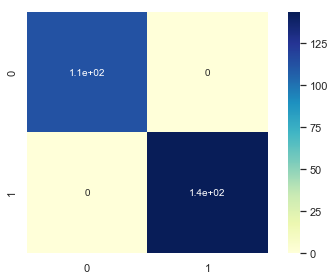

Sensitivity (True Positives Rate): 1.0
Specificity (True Negatives Rate): 1.0


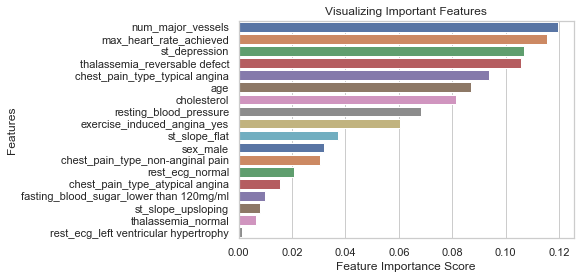

In [32]:
model = RandomForestClassifier(random_state=50, criterion='gini',
                               n_estimators=bestF.best_estimator_.n_estimators,
                               max_features=bestF.best_estimator_.max_features,
                               max_depth=bestF.best_estimator_.max_depth)

model = model.fit(X_train, Y_train)
prediction = model.predict(X_test)
accuracy = accuracy_score(Y_test, prediction)
print("Accuracy Score (with Hyperparameters Tuning):", "{}%".format(np.round(100*accuracy,3)))

do_confusion_matrix(Y_test, prediction)
do_feature_importance(model, X_scaled, Y)

model = None
prediction = None
accuracy = None



##### Cross Validation

In [ ]:
model = RandomForestClassifier(random_state=50, criterion='gini',
                               n_estimators=bestF.best_estimator_.n_estimators,
                               max_features=bestF.best_estimator_.max_features,
                               max_depth=bestF.best_estimator_.max_depth)

accuracyCV = cross_val_score(model, X_scaled, Y, cv = 10, scoring = 'accuracy')
print("Cross Validation Scores")
plt.plot(accuracyCV, '.-b', label="Accuracy CV")
plt.ylabel('Accuracy score')
plt.show()
print("CV Mean Accuracy Score:", np.round(100*np.mean(accuracyCV), 3), "%")
print("CV STD Accuracy Score:", np.round(100*np.std(accuracyCV), 3), "%"))
model = None
accuracyCV = None